In [11]:
import config
import torch
import numpy as np
import matplotlib

from dataset import SyntheticDataset1
from torch import nn, Tensor
from variational.nn import IsotropicGaussian, Sequential



## Deterministic

In [22]:
class DeterministicModel(nn.Module):
    def __init__(self) -> None:
        super(DeterministicModel, self).__init__()
        self.net = Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 1),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)

In [23]:
dataset = SyntheticDataset1(1000, .8)
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader

model = DeterministicModel()
optimizer = Adam(model.parameters(), lr=1e-1)
loss = MSELoss()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for epoch in range(1000):
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = model(x)
        l = loss(y_hat.ravel(), y)
        l.backward()
        optimizer.step()
    print(f'Epoch {epoch}: {l.item()}')

Epoch 0: 1.6354511976242065
Epoch 1: 0.14531226456165314
Epoch 2: 0.5351494550704956
Epoch 3: 0.8582406640052795
Epoch 4: 0.4478829801082611
Epoch 5: 0.641584038734436
Epoch 6: 0.48170769214630127
Epoch 7: 0.3804011642932892
Epoch 8: 0.2800401449203491
Epoch 9: 0.15912234783172607
Epoch 10: 0.11033137142658234
Epoch 11: 0.4154290556907654
Epoch 12: 0.8838856220245361
Epoch 13: 0.5036556720733643
Epoch 14: 0.4083545207977295
Epoch 15: 0.41443800926208496
Epoch 16: 0.18474647402763367
Epoch 17: 0.14287465810775757
Epoch 18: 1.1839685440063477
Epoch 19: 0.11751669645309448
Epoch 20: 0.5617361664772034
Epoch 21: 0.3011433780193329
Epoch 22: 0.42273908853530884
Epoch 23: 0.20175763964653015
Epoch 24: 0.5539889931678772
Epoch 25: 0.1283983588218689
Epoch 26: 0.4402139186859131
Epoch 27: 0.2805418074131012
Epoch 28: 0.1637328863143921
Epoch 29: 1.76768958568573
Epoch 30: 0.14585158228874207
Epoch 31: 1.0277185440063477
Epoch 32: 0.3266858160495758
Epoch 33: 0.562972366809845
Epoch 34: 0.33155

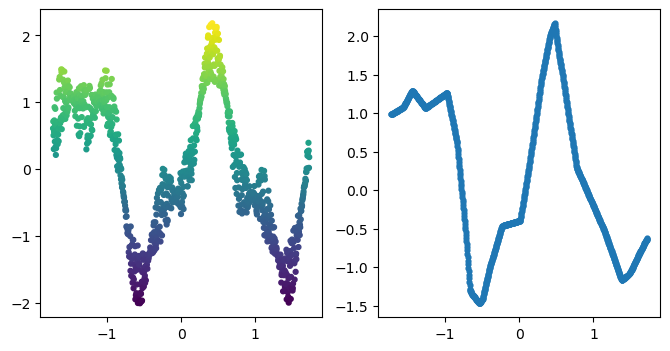

In [24]:
from matplotlib import pyplot as plt
y = model(dataset.X).detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].scatter(dataset.X, dataset.y, c=dataset.y, s=12)
ax[1].scatter(dataset.X.ravel(), y.ravel(), s=12)
# colorbar in ax[1]
plt.show()

In [74]:
from torch import nn
import variational.nn as vnn 

class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.encode = vnn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            IsotropicGaussian(16, 2)
        )

        self.decode= nn.Linear(2, 1)

    def forward(self, x, n_samples):
        y = self.encode(x, n_samples)
        return self.decode(y).mean(0)
    


toyModel = ToyModel()

x = torch.randn(3, 1, dtype=torch.float32)
y = toyModel(x, 2)

# mu, sigma = toyModel.encode[9].mu, toyModel.encode[9].sigma
# print(y.shape, mu, sigma)

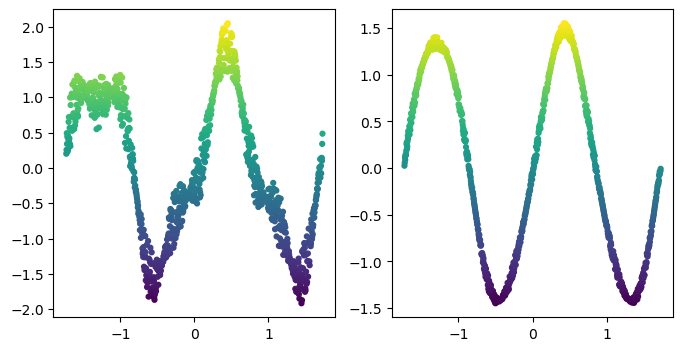

In [94]:
from dataset import SyntheticDataset1

train_dataset = SyntheticDataset1(1000, .6)
test_dataset = SyntheticDataset1(1000, .1)

from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(train_dataset.X, train_dataset.y, c=train_dataset.y, s=12)
ax[1].scatter(test_dataset.X, test_dataset.y, c=test_dataset.y, s=12)
plt.show()

In [95]:
from torch.nn.functional import mse_loss
from torch.optim import Adam
from torch.utils.data import DataLoader
from variational.loss import SGVBL

model = ToyModel()
optimizer = Adam(model.parameters(), lr=1e-3)
# loss = SGVBL(model, len(dataset), mle=mse_loss)
loss = SGVBL(model, 1, mle=mse_loss)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for epoch in range(1000):
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = model(x, 100)
        l = loss(y_hat, y, 1e-3)
        l.backward()
        optimizer.step()
    print(f'Epoch {epoch}: {l.item()}')



/home/ahguedes/WorkSpace/Thesis/UncertaintyBottleneck/variational/loss/SGVBL.py:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return self.train_size * (self.loss(input, target, reduction='mean') + kl_weight * kl)
/home/ahguedes/WorkSpace/Thesis/UncertaintyBottleneck/variational/loss/SGVBL.py:34: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return self.train_size * (self.loss(input, target, reduction='mean') + kl_weight * kl)


Epoch 0: 0.6401352286338806
Epoch 1: 1.7855335474014282
Epoch 2: 1.1530084609985352
Epoch 3: 0.8913015723228455
Epoch 4: 1.0374712944030762
Epoch 5: 1.3058812618255615
Epoch 6: 1.4569770097732544
Epoch 7: 1.4574700593948364
Epoch 8: 1.3699218034744263
Epoch 9: 0.4833567142486572
Epoch 10: 0.9238031506538391
Epoch 11: 1.1599736213684082
Epoch 12: 1.1313501596450806
Epoch 13: 1.0840564966201782
Epoch 14: 0.786628007888794
Epoch 15: 0.9041973948478699
Epoch 16: 0.4922110140323639
Epoch 17: 1.1692026853561401
Epoch 18: 0.686714768409729
Epoch 19: 0.8712564706802368
Epoch 20: 0.7806768417358398
Epoch 21: 0.8141375780105591
Epoch 22: 1.1877281665802002
Epoch 23: 0.9463706016540527
Epoch 24: 1.1572517156600952
Epoch 25: 0.6819936633110046
Epoch 26: 0.979554295539856
Epoch 27: 0.8754405975341797
Epoch 28: 1.0928456783294678
Epoch 29: 0.7383611798286438
Epoch 30: 1.1341118812561035
Epoch 31: 1.3734729290008545
Epoch 32: 0.8276313543319702
Epoch 33: 0.32470178604125977
Epoch 34: 0.68626731634140

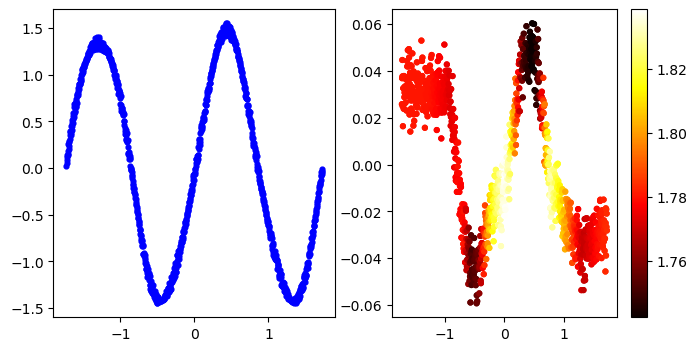

In [97]:
encode = model.encode
_ = encode(test_dataset.X)
mu, std = encode[6].mu.detach().numpy(), encode[6].sigma.detach().numpy()

y = model(test_dataset.X, 100).detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].scatter(test_dataset.X, test_dataset.y, c='blue', s=12)
# ax[1].scatter(dataset.X.ravel(), mu.ravel())
ax[1].scatter(test_dataset.X.ravel(), y.ravel(), c=std.sum(1), s=12, cmap='hot')
# colorbar in ax[1]
cbar = plt.colorbar(ax[1].scatter(dataset.X.ravel(), y.ravel(), c=std.sum(1), s=12, cmap='hot'))
plt.show()

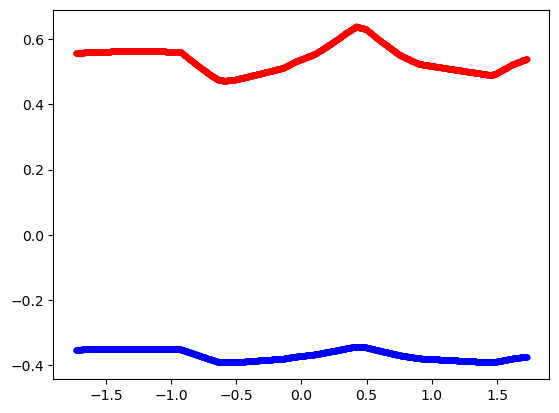

In [100]:
# plt.scatter(dataset.X, dataset.y, c=dataset.y, s=12)
plt.scatter(dataset.X, std.prod(1), c='red', s=12)
plt.scatter(dataset.X, mu.mean(1), c='blue', s=12)



In [96]:
std.shape

(1000, 2)